In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

import string
from random import *
import re
import math
import time

import subprocess, os, glob
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as st

device = 'cuda:5'
print (device)
print(torch.__version__)


cuda:5
1.0.0


In [3]:
BS = 100

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

In [22]:
class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()
        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))
        
        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))
        
    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1
        
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        
        return m_hat / (torch.sqrt(v_hat) + self.eps)

# def MMMLoss(x, pi, mu, reduce=True):
#     x = x.unsqueeze(1)
#     # Negative Log Liklihood of the multinoulis
#     logpi = torch.log(pi)
#     logmu = torch.log(mu)
#     logommu = torch.log(1-mu)

#     logprob = (logpi + (x*logmu + (1-x)*logommu).sum(-1)).sum(-1)
    
#     if (reduce):
#         return -torch.mean(logprob)
#     return -logprob

# def MMMLoss(x, pi, mu, reduce=True):
#     x = x.unsqueeze(1)
#     # Negative Log Liklihood of the multinoulis
#     # This one takes logs last -> might suffer from numerical issues
    
#     nouli_prob = ((mu**x)*((1-mu)**(1-x))).prod(-1)
#     mix_prob = (pi*nouli_prob).sum(-1)
#     log_prob = -torch.log(mix_prob)
    
#     if (reduce):
#         return torch.mean(log_prob)
#     return log_prob

# def MMMLoss(x, pi, mu, reduce=True):
#     x = x.unsqueeze(1)
#     # Negative Log Liklihood of the multinoulis
#     logpi = torch.log(pi)
#     logmu = torch.log(mu)
#     logommu = torch.log(1-mu)

#     mixprob = (logpi + (x*logmu + (1-x)*logommu).sum(-1))
    
#     prob = torch.exp(mixprob).sum(-1)
    
#     logprob = -torch.log(prob)
    
    
#     if (reduce):
#         return torch.mean(logprob)
#     return logprob



def MMMLoss(x, pi, mu, reduce=True):
    x = x.unsqueeze(1)
    # Negative Log Liklihood of the multinoulis
    logpi = torch.log(pi)
    logmu = torch.log(mu)
    logommu = torch.log(1-mu)

    mix_log_probs = (logpi + (x*logmu + (1-x)*logommu).sum(-1))
    max_log_probs = torch.max(mix_log_probs, dim=-1, keepdim=True)[0]
    mix_log_probs = mix_log_probs - max_log_probs

    probs = torch.exp(mix_log_probs).sum(-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob


def dummy(x, pi, mu):
    return x
    
    
class MMN(nn.Module):
    def __init__(self, inputs, noulis, lr=1e-3, Loss=MMMLoss,
                 FeedForward=dummy, pre=None):
        super(MMN, self).__init__()
        self.inputs = inputs
        self.noulis = noulis
        
        self.Pis = nn.Parameter(torch.randn((1, noulis)))
        self.Mus = nn.Parameter(torch.randn((1, noulis, inputs)))
    
        self.Pi_adam = Adam(self.Pis)
        self.Mu_adam = Adam(self.Mus)
        
        self.lr = lr
        
        self.FF = FeedForward
        self._loss = Loss
        self.pre = pre if pre is not None else lambda x:x
    
    def params(self):  
        Pis = F.softmax(self.Pis, dim=1)
        Mus = torch.sigmoid(self.Mus)
        
        return (Pis, Mus)
    
    def forward(self, x, lr=None):
        # This returns both the p vector to higher levels and the dP/dx for feed back
        # If in training mode it will also perform update of this layer's parameters
        
        (pi, mu) = self.params()
        
        xt = torch.zeros_like(x, requires_grad=True)
        xt.data = x
        x = self.pre(xt)
        
        # Do parameter learning
#         if (self.training):
#             self.learn(x, lr)
            
        p = self.FF(x, pi, mu)
        
        # Calculate backwards vector
        loss = self._loss(x, pi, mu)
        loss.backward()
        dpdx = xt.grad
        
        return (p.detach(), dpdx.detach())
    
    def learn(self, x, lr=None):
        
        x = self.pre(x)
        
        (pi, mu) = self.params()
        
        if (lr is None):
            lr = self.lr
            
        self.Pis.grad = torch.zeros_like(self.Pis)
        self.Mus.grad = torch.zeros_like(self.Mus) 
            
        loss = self._loss(x, pi, mu)
        loss.backward()
        
        self.Pis.data  -= lr*self.Pi_adam(self.Pis.grad)
        self.Mus.data  -= lr*self.Mu_adam(self.Mus.grad)
        
        
    def loss(self, x):
        x = self.pre(x)
        (pi, mu) = self.params()
        return self._loss(x, pi, mu)

In [66]:
D = 784
N = BS
lr = 0.001

PS = 0.2

device = 'cuda:5'

net = MMN(D, N, lr).eval()
net.to(device)

# prime the means
(data, _) = next(iter(train_loader))

data = (data > 0.4).float()
data = 2*PS*data - PS
data = data.view(1, -1, 784).to(device)

net.Mus.data = data
# Done priming

s = time.time()
epochs = 30

for e in range(epochs):
    loss = 0
    for (data, label) in train_loader:
        data = data.view(-1,784).to(device)
        data = (data>0.4).float()
#         print (data.shape)
        (p, _) = net(data)
        (pi, mu) = net.params()
        
        loss += MMMLoss(data, pi, mu).item()
        net.learn(data)
            
#         raise ValueError("STOP")

    print ("Epoch {} : {}".format(e, loss))
e = time.time()
print (e-s)


Epoch 0 : 242629.64874267578
Epoch 1 : 186010.46560668945
Epoch 2 : 163164.75666809082
Epoch 3 : 150751.09391784668
Epoch 4 : 143279.6492767334
Epoch 5 : 138498.57943725586
Epoch 6 : 135305.6688232422
Epoch 7 : 133108.1083831787
Epoch 8 : 131561.58920288086
Epoch 9 : 130456.21821594238
Epoch 10 : 129655.94068908691
Epoch 11 : 129071.27334594727
Epoch 12 : 128641.59368896484
Epoch 13 : 128324.205078125
Epoch 14 : 128075.61152648926
Epoch 15 : 127138.51379394531
Epoch 16 : 125317.61042785645
Epoch 17 : 124191.8962097168
Epoch 18 : 123499.72579956055
Epoch 19 : 122974.22253417969
Epoch 20 : 122456.94946289062
Epoch 21 : 121911.17315673828
Epoch 22 : 121423.67094421387
Epoch 23 : 121077.96760559082
Epoch 24 : 120850.45718383789
Epoch 25 : 120700.62730407715
Epoch 26 : 120602.82328796387
Epoch 27 : 120538.4017944336
Epoch 28 : 120495.04678344727
Epoch 29 : 120464.88055419922
329.36454677581787


tensor([97, 96, 98, 99, 73, 72, 74, 75, 67, 66, 64, 65, 69, 68, 70, 71, 87, 86,
        84, 85, 81, 80, 82, 83, 91, 90, 88, 89, 93, 92, 94, 95, 79, 78, 76, 77,
        41, 40, 42, 43, 35, 34, 32, 33, 37, 36, 38, 39, 55, 54, 52, 53, 49, 48,
        50, 51, 59, 58, 56, 57, 61, 60, 62, 63, 31, 30, 28, 29, 25, 24, 26, 27,
        19, 18, 16, 17, 21, 20, 22, 23,  7,  6,  4,  5,  1,  0,  2,  3, 11, 10,
         8,  9, 13, 12, 14, 15, 47, 46, 44, 45], device='cuda:5')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:5')


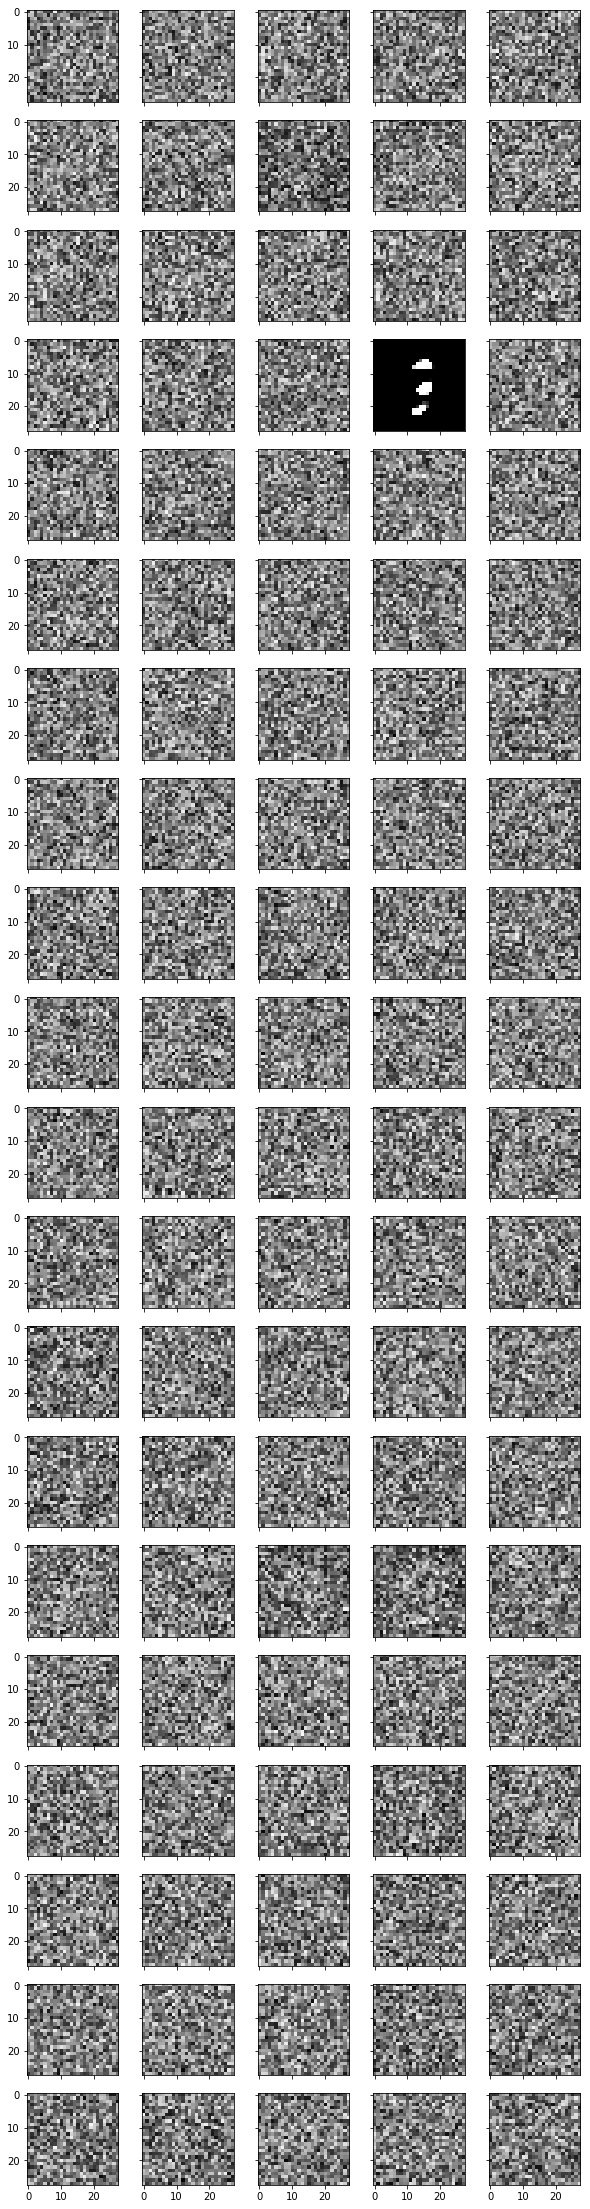

In [81]:
def plotMeans(L, N=None):
    

    (pi, mu) = L.params()
    pi = pi.squeeze()
    mu = mu.squeeze()
    vp,pp = pi.sort(descending=True)
    print (pp)
    print (vp)
    
    if (N is None):
        N = pi.shape[0]

    pmu = mu[pp].view(-1,28,28).detach().cpu()
    rows = N//5

    fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
    for i in range(N):
        px = i//5
        py = i%5
        ax[px,py].imshow(pmu[i], cmap='gray', vmin=0, vmax=1)
    plt.show()
    
    
# (pi, mu) = net.params()
# print (pi)
# print (mu)
# # net = net.cpu()
plotMeans(net)


In [50]:
D1 = 5
D2 = 0
N = 100
lr = 0.001

noise_prob = 0.05

device = 'cuda:5'

net = MMN(2*D1+D2, N, lr).eval()
net.to(device)


s = time.time()
epochs = 30

for e in range(epochs):
    loss = 0
    for (data, label) in train_loader:
        data1 = torch.randint(2,(100, D1)).float()
        data2 = torch.randint(2,(100, D2)).float()
        noise = (torch.rand((100,2*D1+D2))<noise_prob).float()
        data = torch.cat([data1, data1, data2], 1)
        data = data + noise
        
        data = data.to(device)

        (p, _) = net(data)
        (pi, mu) = net.params()
        
        loss += MMMLoss(data, pi, mu).item()
        net.learn(data)
            
#         raise ValueError("STOP")

    print ("Epoch {} : {}".format(e, loss))
e = time.time()
print (e-s)


(pi, mu) = net.params()
pi = pi.squeeze()
mu = mu.squeeze()
vp,pp = pi.sort(descending=True)
print (pp)
print (vp)


pmu = mu[pp].cpu()
print (pmu[:12,:2*D1])

Epoch 0 : 3778.021800518036
Epoch 1 : 3319.900981426239
Epoch 2 : 2943.193736553192
Epoch 3 : 2664.801676273346
Epoch 4 : 2486.5630252361298
Epoch 5 : 2359.3589622974396
Epoch 6 : 2249.0187089443207
Epoch 7 : 2188.4583168029785
Epoch 8 : 2125.730075120926
Epoch 9 : 2067.1238090991974
Epoch 10 : 2035.2482221126556
Epoch 11 : 1997.3850400447845
Epoch 12 : 1952.7700095176697
Epoch 13 : 1915.056807756424
Epoch 14 : 1882.7139880657196
Epoch 15 : 1847.7331721782684
Epoch 16 : 1847.7543736696243
Epoch 17 : 1783.730639219284
Epoch 18 : 1749.112587571144
Epoch 19 : 1718.893019914627
Epoch 20 : 1692.4854362010956
Epoch 21 : 1651.7990208864212
Epoch 22 : 1602.3816148042679
Epoch 23 : 1565.5160211324692
Epoch 24 : 1563.3585678339005
Epoch 25 : 1502.208621263504
Epoch 26 : 1454.5791858434677
Epoch 27 : 1454.3142939805984
Epoch 28 : 1400.9094848036766
Epoch 29 : 1389.2349786758423
275.4818935394287
tensor([72, 39, 10, 65, 33, 44, 74, 83, 76, 47, 86, 19, 93,  7, 32, 85, 95, 90,
        24, 27, 49, 18

In [40]:
print (pmu[:4,:D1]>0.5)
print (pmu[:4,D1:2*D1]>0.5)

tensor([[0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]],
       dtype=torch.uint8)
tensor([[0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]],
       dtype=torch.uint8)


In [17]:
def MMMLoss(x, pi, mu, reduce=True):
    x = x.unsqueeze(1)
    # Negative Log Liklihood of the multinoulis
    # This one takes logs last -> might suffer from numerical issues
    
    nouli_prob = ((mu**x)*((1-mu)**(1-x))).prod(-1)
    mix_prob = (pi*nouli_prob).sum(-1)
    log_prob = -torch.log(mix_prob)
    
    if (reduce):
        return torch.mean(log_prob)
    return log_prob

x = torch.randint(2,(5,3)).float()
mu = torch.sigmoid(torch.randn((1,2,3)))
pi = F.softmax(torch.randn((1,2)), -1)

print (x)
print (mu)
print (pi)

MMMLoss(x, pi, mu)

tensor([[1., 1., 1.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 1., 0.],
        [0., 0., 1.]])
tensor([[[0.4477, 0.2419, 0.1871],
         [0.8498, 0.6222, 0.7659]]])
tensor([[0.7931, 0.2069]])
+++++++++++++++++
torch.Size([5, 1, 3])
torch.Size([1, 2])
torch.Size([1, 2, 3])
---------
torch.Size([5, 2, 3])
tensor([[[0.4477, 0.2419, 0.1871],
         [0.8498, 0.6222, 0.7659]],

        [[1.0000, 1.0000, 0.1871],
         [1.0000, 1.0000, 0.7659]],

        [[1.0000, 0.2419, 0.1871],
         [1.0000, 0.6222, 0.7659]],

        [[0.4477, 0.2419, 1.0000],
         [0.8498, 0.6222, 1.0000]],

        [[1.0000, 1.0000, 0.1871],
         [1.0000, 1.0000, 0.7659]]])
tensor([[0.0203, 0.4050],
        [0.0783, 0.0434],
        [0.0250, 0.0716],
        [0.0881, 0.1238],
        [0.0783, 0.0434]])
tensor([0.0999, 0.0711, 0.0346, 0.0955, 0.0711])
tensor([2.3040, 2.6437, 3.3631, 2.3491, 2.6437])


tensor(2.6607)

In [69]:
Mus = torch.sigmoid(torch.randn((10000)))
print (Mus.min(), Mus.mean(), Mus.max())


tensor(0.0176) tensor(0.4974) tensor(0.9764)


In [89]:
def SoftL1Act(x, pi, mu):
    with torch.no_grad():
        x = x.unsqueeze(1)
        l1dist = (x-mu).abs().sum(-1)
        act = F.softmax(-l1dist, dim=-1)
    return act

def MinL1Act(x, pi, mu):
    with torch.no_grad():
        x = x.unsqueeze(1)
        l1dist = (x-mu).abs().sum(-1)
        l1min = l1dist.min(-1, keepdim=True)[0]
        act = ((l1dist - l1min - 0.01) < 0).float()
    return act    

def L1Loss(x, act, mu):
    x = x.unsqueeze(1)
    l1dist = (x-mu).abs().sum(-1)
    total_loss = (act*l1dist).sum(-1)
    return total_loss.mean()

class M3(nn.Module):
    def __init__(self, inputs, num_means, lr=1e-3, Loss=L1Loss,
                 Activation=SoftL1Act,
                 FeedForward=dummy, pre=None):
        super(M3, self).__init__()
        self.inputs = inputs
        self.num_means = num_means
        
        self.Pis = nn.Parameter(torch.zeros(num_means), requires_grad=False)
        self.Mus = nn.Parameter(torch.randn((1, num_means, inputs)))
    
        self.Mu_adam = Adam(self.Mus)
        
        self.lr = lr
        
        self.FF = FeedForward
        self.Activation = Activation
        self._loss = Loss
        self.pre = pre if pre is not None else lambda x:x
    
    def params(self):
        Mus = torch.sigmoid(self.Mus)
        
        return (self.Pis, Mus)
    
    def forward(self, x, lr=None):
        # This returns both the p vector to higher levels and the dP/dx for feed back
        # If in training mode it will also perform update of this layer's parameters
        
        (pi, mu) = self.params()
        
        xt = torch.zeros_like(x, requires_grad=True)
        xt.data = x
        x = self.pre(xt)
        
        # Do parameter learning
#         if (self.training):
#             self.learn(x, lr)
            
        act = self.Activation(x, pi, mu)
        
        # Calculate backwards vector
        loss = self._loss(x, act, mu)
        loss.backward()
        dpdx = xt.grad
        
        return (act.detach(), dpdx.detach())
    
    def learn(self, x, lr=None):
        
        x = self.pre(x)
        
        (pi, mu) = self.params()
        
        if (lr is None):
            lr = self.lr
            
        self.Mus.grad = torch.zeros_like(self.Mus) 
        
        act = self.Activation(x, pi, mu)
        
        loss = self._loss(x, act, mu)
        loss.backward()
        
        self.Mus.data  -= lr*self.Mu_adam(self.Mus.grad)
        
        
    def loss(self, x):
        x = self.pre(x)
        (pi, mu) = self.params()
        act = self.Activation(x, pi, mu)
        return self._loss(x, act, mu)

In [90]:
D = 784
N = BS
lr = 0.001

PS = 1

device = 'cuda:5'

net = M3(D, N, lr, Activation=MinL1Act).eval()
net.to(device)

# prime the means
(data, _) = next(iter(train_loader))

data = (data > 0.4).float()
data = 2*PS*data - PS
data = data.view(1, -1, 784).to(device)

net.Mus.data = data
# Done priming

s = time.time()
epochs = 30

for e in range(epochs):
    loss = 0
    for (data, label) in train_loader:
        data = data.view(-1,784).to(device)
        data = (data>0.4).float()
#         print (data.shape)
        (p, _) = net(data)
        (pi, mu) = net.params()
        
        loss += net.loss(data).item()
        net.learn(data)
            
#         raise ValueError("STOP")

    print ("Epoch {} : {}".format(e, loss))
e = time.time()
print (e-s)


Epoch 0 : 127815.3141784668
Epoch 1 : 96793.71925354004
Epoch 2 : 82448.94303131104
Epoch 3 : 74962.28156280518
Epoch 4 : 70275.7509841919
Epoch 5 : 66983.59043884277
Epoch 6 : 64442.22245788574
Epoch 7 : 62415.382804870605
Epoch 8 : 60871.07440948486
Epoch 9 : 59506.07102203369
Epoch 10 : 58308.151138305664
Epoch 11 : 57417.49817657471
Epoch 12 : 56763.13503265381
Epoch 13 : 56253.89924621582
Epoch 14 : 55743.90187072754
Epoch 15 : 55257.606941223145
Epoch 16 : 54833.701332092285
Epoch 17 : 54529.279296875
Epoch 18 : 54280.71174621582
Epoch 19 : 54089.972984313965
Epoch 20 : 53932.10479736328
Epoch 21 : 53783.99726867676
Epoch 22 : 53679.39276885986
Epoch 23 : 53577.627113342285
Epoch 24 : 53491.72051239014
Epoch 25 : 53407.83752441406
Epoch 26 : 53344.7303314209
Epoch 27 : 53289.51153564453
Epoch 28 : 53243.435607910156
Epoch 29 : 53213.91205596924
284.5013380050659


tensor([97, 96, 98, 99, 73, 72, 74, 75, 67, 66, 64, 65, 69, 68, 70, 71, 87, 86,
        84, 85, 81, 80, 82, 83, 91, 90, 88, 89, 93, 92, 94, 95, 79, 78, 76, 77,
        41, 40, 42, 43, 35, 34, 32, 33, 37, 36, 38, 39, 55, 54, 52, 53, 49, 48,
        50, 51, 59, 58, 56, 57, 61, 60, 62, 63, 31, 30, 28, 29, 25, 24, 26, 27,
        19, 18, 16, 17, 21, 20, 22, 23,  7,  6,  4,  5,  1,  0,  2,  3, 11, 10,
         8,  9, 13, 12, 14, 15, 47, 46, 44, 45], device='cuda:5')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:5')


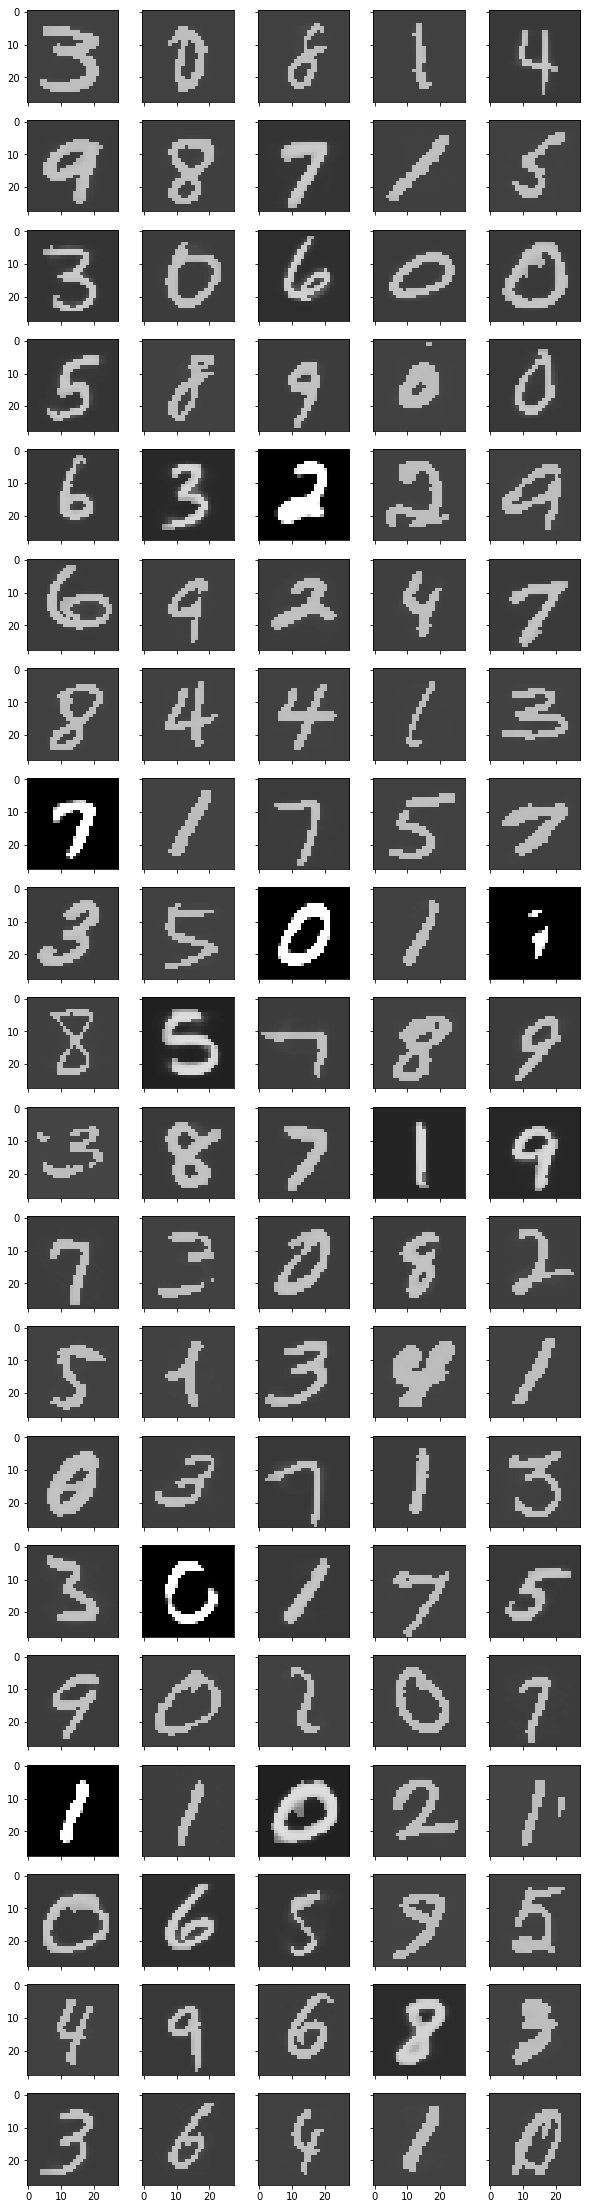

In [91]:
plotMeans(net)